# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# 1. Prepare and merge the datasets

In [2]:
df_google_first = pd.read_csv('app_sdk/google_data_first.csv', encoding='ISO-8859-1')
df_google_first = df_google_first.loc[:, ~df_google_first.columns.str.contains('^Unnamed')]

In [3]:
df_google_last = pd.read_csv('app_sdk/google_data_last.csv', encoding='ISO-8859-1')
df_google_last = df_google_last.loc[:, ~df_google_last.columns.str.contains('^Unnamed')]

In [4]:
missing_rows = df_google_first[~df_google_first['my_app_id'].isin(df_google_last['my_app_id'])]

df = pd.concat([df_google_last, missing_rows], ignore_index=True)

# 2. Analyze dataframe

In [5]:
def dataframe_summary(df):
    print(f"DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    df_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage (%)': (df.isnull().sum() / len(df)) * 100
    })
    print(df_info)

# Run the function to get an enhanced summary of the DataFrame
# dataframe_summary(df)

# 2. Preprocess DataFrame

In [6]:
# Use specific columns
df = df[['my_app_id', 'num_downloads', 'rating_app', 'nb_rating', 'price_gplay', 'in_app', 'content_rating_app', 'categ_app', 'date_published', 'has_ads', 'family_library']]

## 2.1 Classify Apps into "Free", "Paid", "Freemium"

In [7]:
# Drop rows where no numeric part is found (if desired)
df = df.dropna(subset=['price_gplay'])

In [8]:
# List of currency symbols and codes to match, including €
currency_codes = ["€", "£", "$", "USD", "CZK", "EUR", "RUB", "AUD", "GBP", "JPY", "CAD", "KRW", "INR", "AED", 
                  "DKK", "SAR", "PLN", "UAH", "SEK", "IDR", "TRY", "TWD", "ILS", "HKD", "BGN", "MXN", "MYR", 
                  "BRL", "CLP", "CHF", ""]

# Create a regex pattern to match the symbols and codes
currency_pattern = r'|'.join(map(re.escape, currency_codes))

df_filtered = df.copy()

# Remove currency symbols and codes
df_filtered['price_value'] = df_filtered['price_gplay'].apply(lambda x: re.sub(currency_pattern, '', x).strip() if isinstance(x, str) else None)

df_filtered['price_value'] = df_filtered['price_value'].str.replace(',', '.')

# remove initial-scale=1. minimum-scale " hre
df_filtered['price_value'] = df_filtered['price_value'].str.replace('initial-scale=1. minimum-scale " hre', '')

# remove empty strings
df_filtered = df_filtered[df_filtered['price_value'] != '']

# convert to float
df_filtered['price_value'] = df_filtered['price_value'].astype(float)

In [9]:
# Categorize apps based on 'price_value'
df_filtered['price_category'] = df_filtered['price_value'].apply(lambda x: "free" if x == 0 else "paid")

# Identify freemium apps where in_app == 1 and price_category == "free"
df_filtered['price_category'] = df_filtered.apply(lambda row: "freemium" if row['price_category'] == "free" and row['in_app'] == 1 else row['price_category'], axis=1)

# Separate paid, free, and freemium apps
paid_apps = df_filtered[df_filtered['price_category'] == "paid"]
free_apps = df_filtered[df_filtered['price_category'] == "free"]
freemium_apps = df_filtered[df_filtered['price_category'] == "freemium"]

## 2.2 Number of Downloads

In [10]:
# Function to clean and convert to numbers
def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    else:
        # Remove ',' and '+' and '>' and strip any whitespace
        cleaned_value = value.replace(',', '').replace('+', '').replace('>', '').strip()
        return int(cleaned_value)

# Apply the function to the DataFrame column
df_filtered['num_downloads'] = df_filtered['num_downloads'].apply(convert_to_numeric)

## 2.3 Ratings

In [11]:
df_filtered = df_filtered.dropna()

In [12]:
# convert 76,545 to 76545
df_filtered['nb_rating'] = df_filtered['nb_rating'].str.replace(',', '')

df_filtered['nb_rating'] = pd.to_numeric(df_filtered['nb_rating'])
df_filtered['rating_app'] = pd.to_numeric(df_filtered['rating_app'])

# Calculate the global average rating across all apps
global_mean_rating = df_filtered['rating_app'].mean()

# Define a prior weight (m)
# This is the number of ratings at which the average rating is considered reliable.
# Adjust based on your data; higher values give more weight to the global mean.
m = 50

# Calculate Bayesian average for each app
df_filtered['bayesian_average'] = (global_mean_rating * m + df_filtered['rating_app'] * df_filtered['nb_rating']) / (m + df_filtered['nb_rating'])


## 2.4 Content Rating

In [13]:
# Applying the regex matching approach to the 'content_rating_app' column in df_content
df_filtered["content_rating_app"] = [
    match.group() if (match := re.match(r'PEGI (3|7|12|16|18)', item)) else item 
    for item in df_filtered["content_rating_app"]
]

# if content_rating_app contains 'not yet been rated', set to 'not yet been rated'
# Ensure the column is of type 'object' (which can store both strings and integers)
df_filtered['content_rating_app'] = df_filtered['content_rating_app'].astype('object')

# Now you can safely assign the string value
df_filtered.loc[df_filtered['content_rating_app'].str.contains('not yet been rated'), 'content_rating_app'] = 'not yet been rated'

## 2.5 Dates

In [14]:
df_filtered['date_published'] = pd.to_datetime(df_filtered['date_published'], errors='coerce')

C:\Users\Kevin\AppData\Local\Temp\ipykernel_33588\3245377716.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtered['date_published'] = pd.to_datetime(df_filtered['date_published'], errors='coerce')


# 3. Graphs

## 3.1 Main observations

### 3.1.1 Date Published

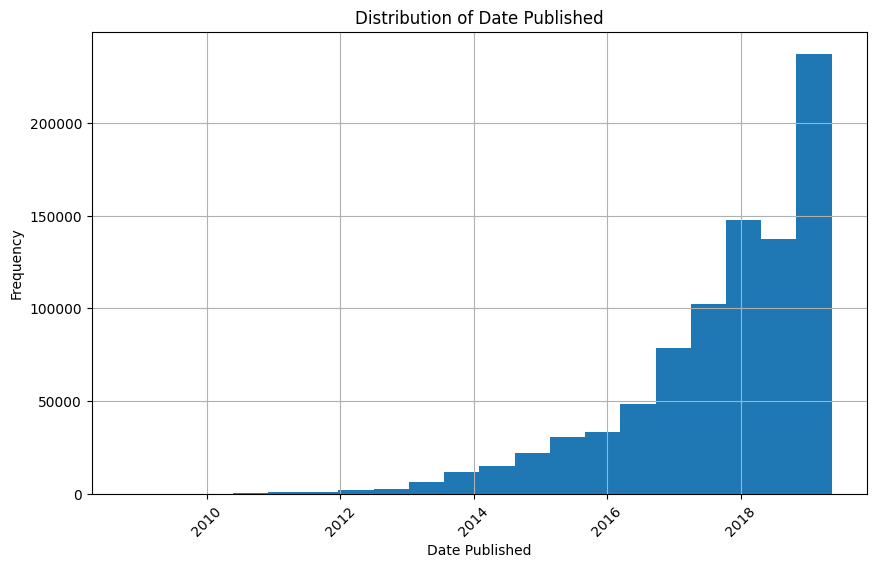

In [15]:
# histogram when apps are published
df_filtered['date_published'].hist(bins=20, figsize=(10, 6))
plt.xlabel('Date Published')
plt.ylabel('Frequency')
plt.title('Distribution of Date Published')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### 3.1.2 Rating

#### 3.1.2.1 Distribution of Ratings

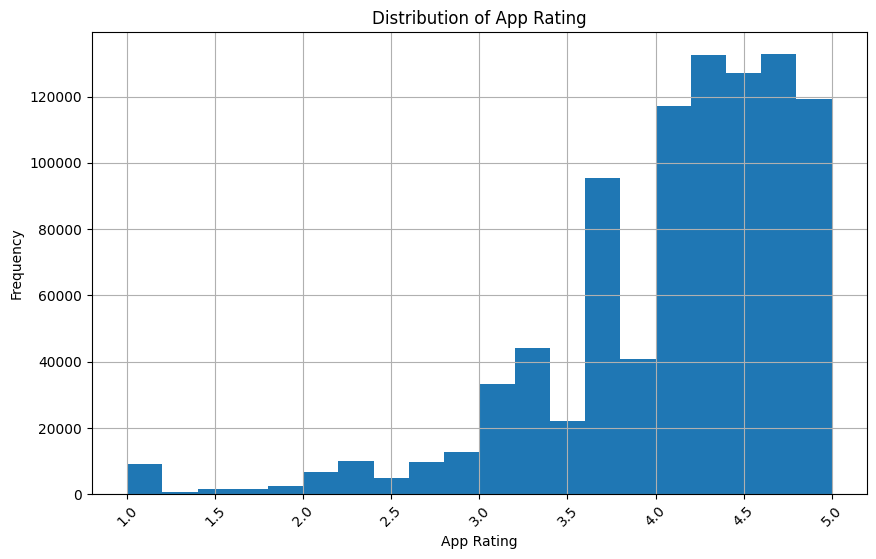

In [16]:
# Plot histogram
df_filtered['rating_app'].hist(bins=20, figsize=(10, 6))
plt.xlabel('App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### 3.1.2.2 Distribution of Bayesian Ratings

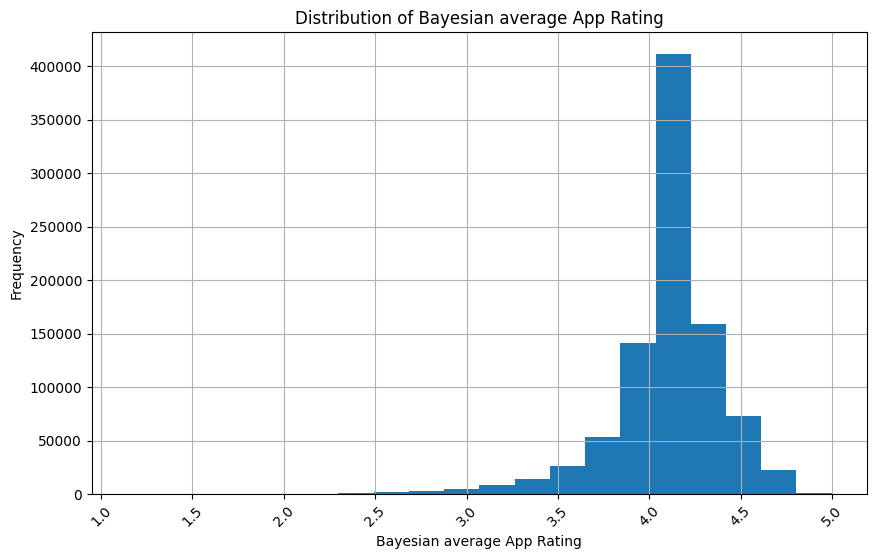

In [17]:
# Plot histogram
df_filtered['bayesian_average'].hist(bins=20, figsize=(10, 6))
plt.xlabel('Bayesian average App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Bayesian average App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### 3.1.3 Number of downloads

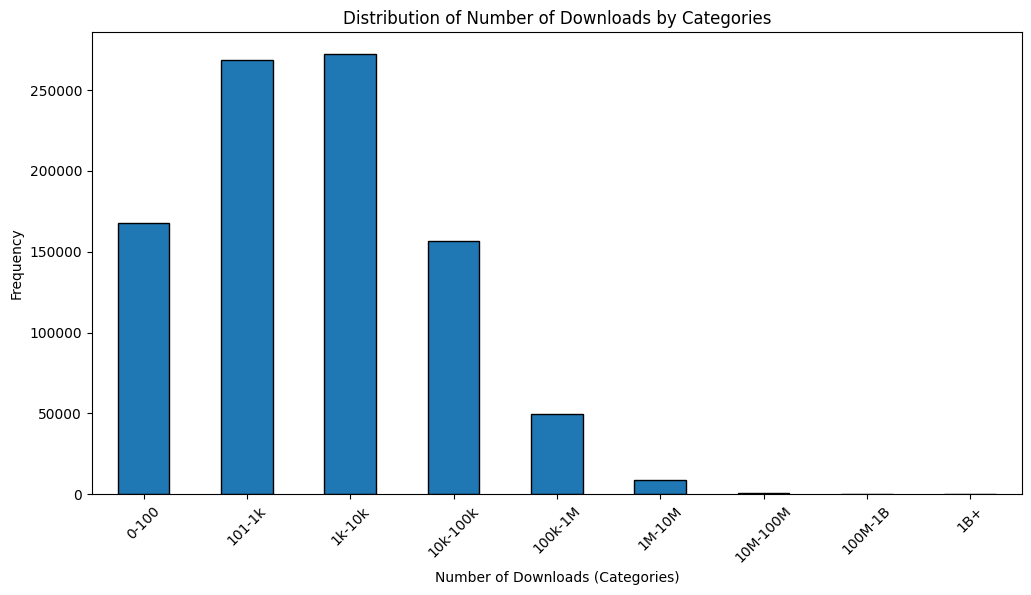

In [18]:
# Define the bins for categorization
bins = [0, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, np.inf]
labels = ['0-100', '101-1k', '1k-10k', '10k-100k', '100k-1M', '1M-10M', '10M-100M', '100M-1B', '1B+']

# Categorize num_downloads into these bins
df_filtered['downloads_category'] = pd.cut(df_filtered['num_downloads'], bins=bins, labels=labels)

# Plot the distribution of num_downloads categories
plt.figure(figsize=(12, 6))
df_filtered['downloads_category'].value_counts(sort=False).plot(kind='bar', edgecolor='black')
plt.xlabel('Number of Downloads (Categories)')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Downloads by Categories')
plt.xticks(rotation=45)
plt.show()

### 3.1.4 WARNING: Prices (this is not adjusted to currencies)

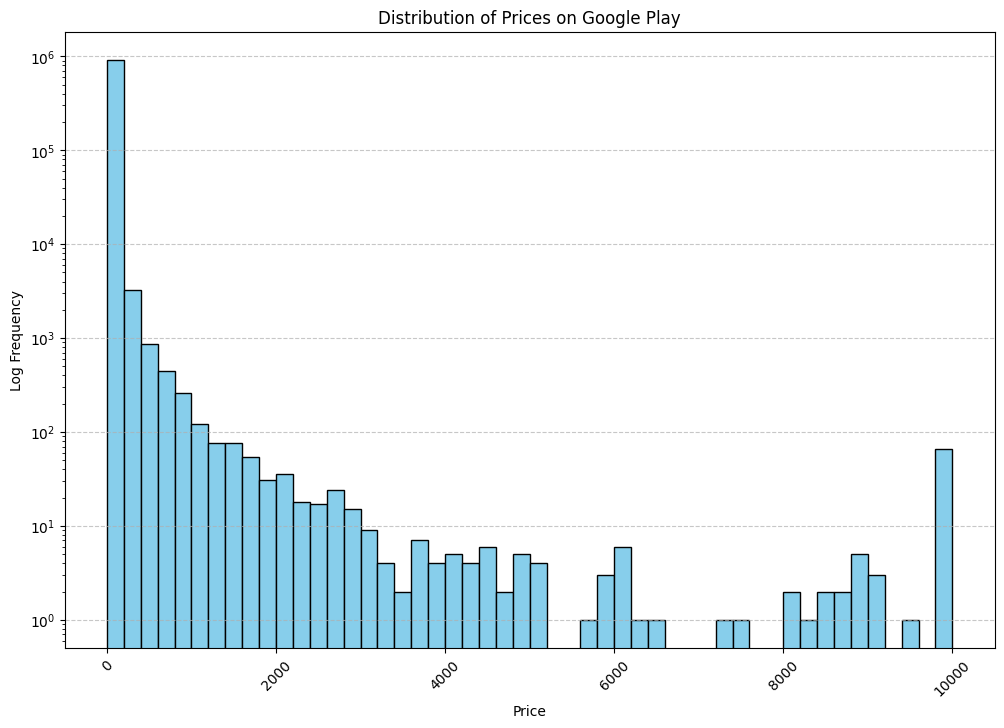

In [19]:
plt.figure(figsize=(12, 8))
plt.hist(df_filtered['price_value'], bins=50, edgecolor="black", color="skyblue", range=(-1, max(df_filtered['price_value']) + 1))
plt.yscale("log")  # Log scale to better visualize frequencies

# Adding labels and title
plt.title("Distribution of Prices on Google Play")
plt.xlabel("Price")
plt.ylabel("Log Frequency")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.1.5 Content Ratings

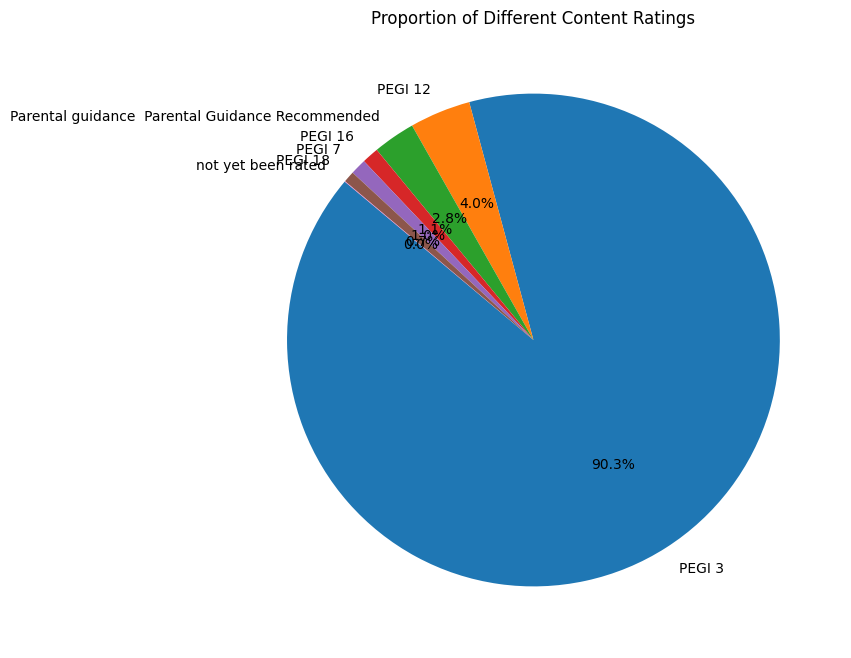

In [20]:
plt.figure(figsize=(8, 8))
content_rating_counts = df_filtered["content_rating_app"].value_counts(normalize=True) * 100  # percentage
content_rating_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Different Content Ratings")
plt.ylabel("")  # Hide y-axis label for cleaner look
plt.show()

### 3.1.6 Category of apps

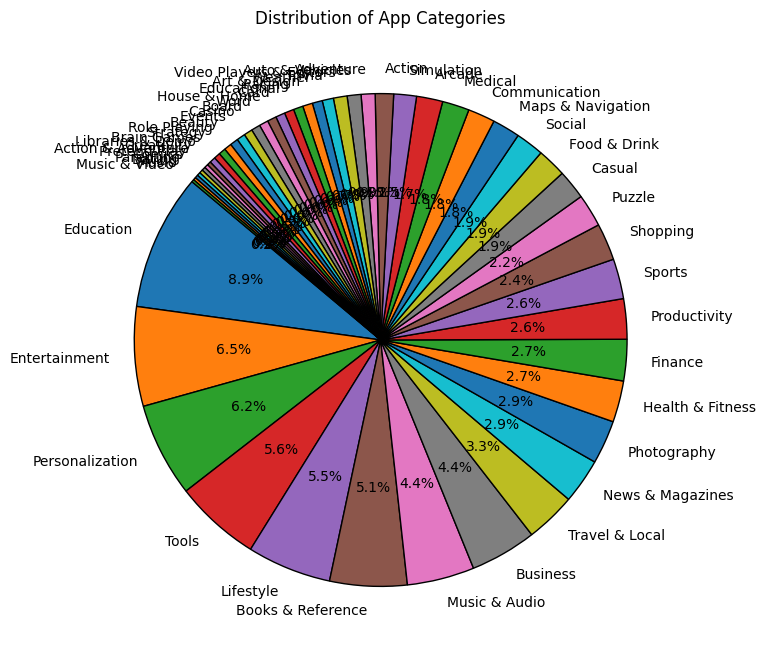

In [21]:
category_counts = df_filtered['categ_app'].value_counts()

plt.figure(figsize=(8, 8))

category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})

plt.title("Distribution of App Categories")

plt.ylabel("")  # Hide y-axis label for cleaner look

plt.show()

### 3.1.7 Apps with in-app purchases and ads

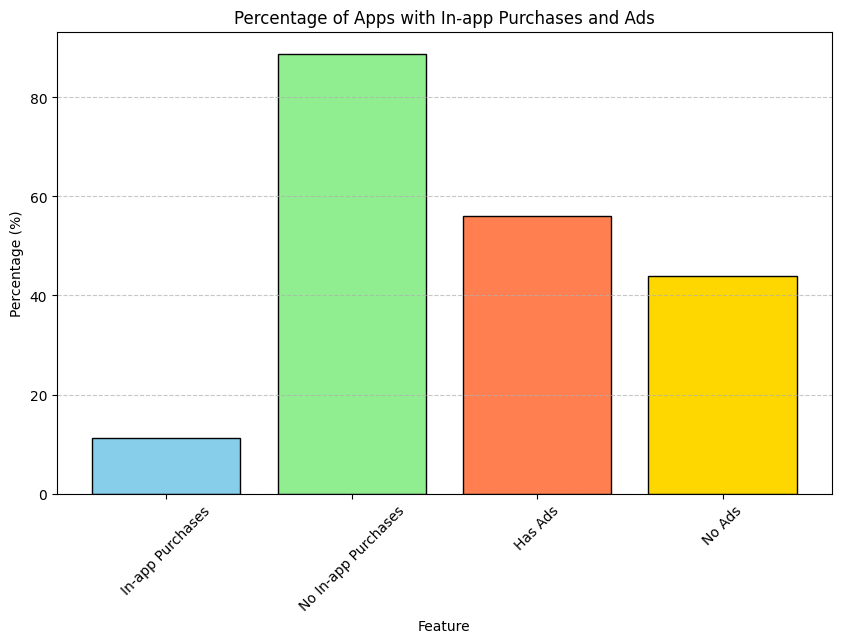

In [22]:
in_app_percentage = df_filtered["in_app"].value_counts(normalize=True) * 100
has_ads_percentage = df_filtered["has_ads"].value_counts(normalize=True) * 100

# Creating a DataFrame for plotting
percentage_data = pd.DataFrame({
    "Feature": ["In-app Purchases", "No In-app Purchases", "Has Ads", "No Ads"],
    "Percentage": [in_app_percentage[True], in_app_percentage[False], has_ads_percentage[True], has_ads_percentage[False]]
})



# Plotting the bar plot for percentages of apps with in-app purchases and ads
plt.figure(figsize=(10, 6))
plt.bar(percentage_data["Feature"], percentage_data["Percentage"], color=['skyblue', 'lightgreen', 'coral', 'gold'], edgecolor='black')
plt.title("Percentage of Apps with In-app Purchases and Ads")
plt.xlabel("Feature")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.1.8 Family Library Support

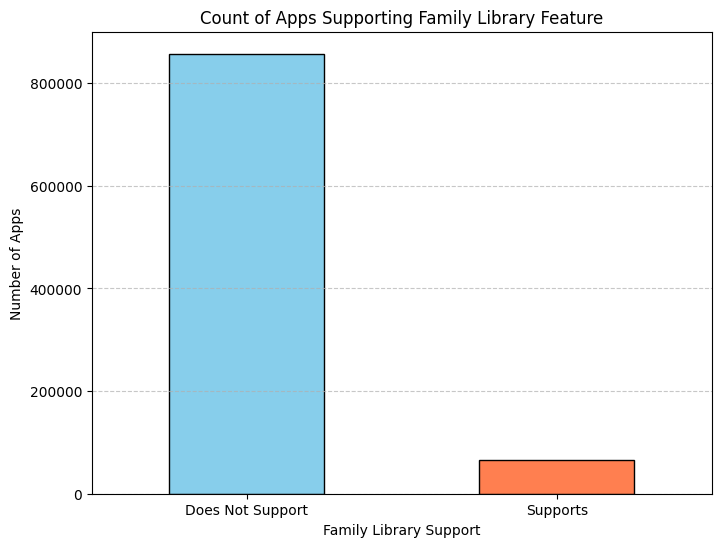

In [23]:
family_library_counts = df_filtered["family_library"].value_counts()

# Plotting the count of apps supporting or not supporting the family library feature
plt.figure(figsize=(8, 6))
family_library_counts.plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title("Count of Apps Supporting Family Library Feature")
plt.xlabel("Family Library Support")
plt.ylabel("Number of Apps")
plt.xticks([0, 1], labels=["Does Not Support", "Supports"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.1.9 Average app rating per category

<Figure size 1200x600 with 0 Axes>

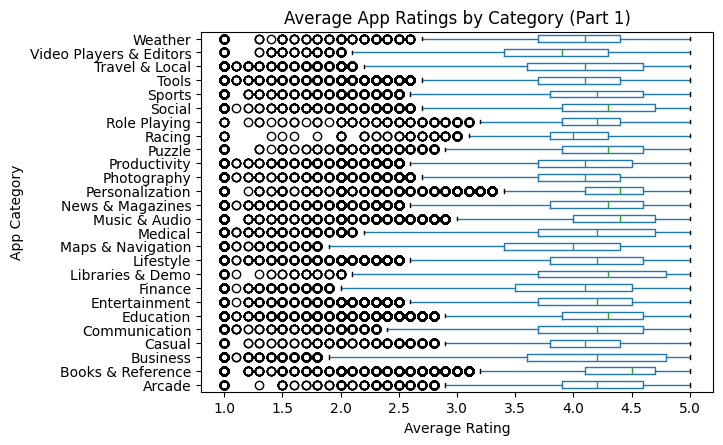

<Figure size 1200x600 with 0 Axes>

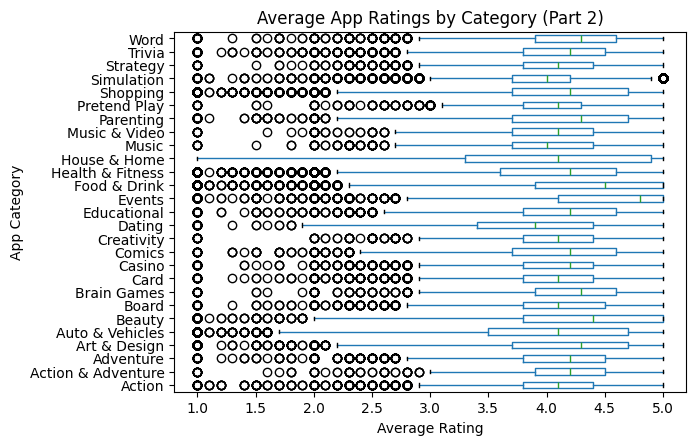

In [24]:
# Splitting categories into two parts for better readability
unique_categories = df_filtered["categ_app"].unique()
midpoint = len(unique_categories) // 2
categories_part1 = unique_categories[:midpoint]
categories_part2 = unique_categories[midpoint:]

# Filtering data for each part
df_category_part1 = df_filtered[df_filtered["categ_app"].isin(categories_part1)]
df_category_part2 = df_filtered[df_filtered["categ_app"].isin(categories_part2)]

# Plotting box plot for average app ratings by category (Part 1)
plt.figure(figsize=(12, 6))
df_category_part1.boxplot(column="rating_app", by="categ_app", grid=False, vert=False)
plt.title("Average App Ratings by Category (Part 1)")
plt.suptitle("")  # Remove default title to keep it clean
plt.xlabel("Average Rating")
plt.ylabel("App Category")
plt.show()

# Plotting box plot for average app ratings by category (Part 2)
plt.figure(figsize=(12, 6))
df_category_part2.boxplot(column="rating_app", by="categ_app", grid=False, vert=False)
plt.title("Average App Ratings by Category (Part 2)")
plt.suptitle("")  # Remove default title to keep it clean
plt.xlabel("Average Rating")
plt.ylabel("App Category")
plt.show()


## 3.2 Topic 2: Freemium vs Paid-For Apps observations

### 3.2.1 Subway Surfers

In [25]:
df_filtered[df_filtered['my_app_id'] == 'com.kiloo.subwaysurf']


,my_app_id,num_downloads,rating_app,nb_rating,price_gplay,in_app,content_rating_app,categ_app,date_published,has_ads,family_library,price_value,price_category,bayesian_average,downloads_category
370724,com.kiloo.subwaysurf,1000000000,4.5,30101032,0 USD,True,PEGI 3,Arcade,2019-04-25,True,False,0.0,freemium,4.499999,100M-1B


### 3.2.2 Downloads per price category

#### 3.2.2.1 Total downloads

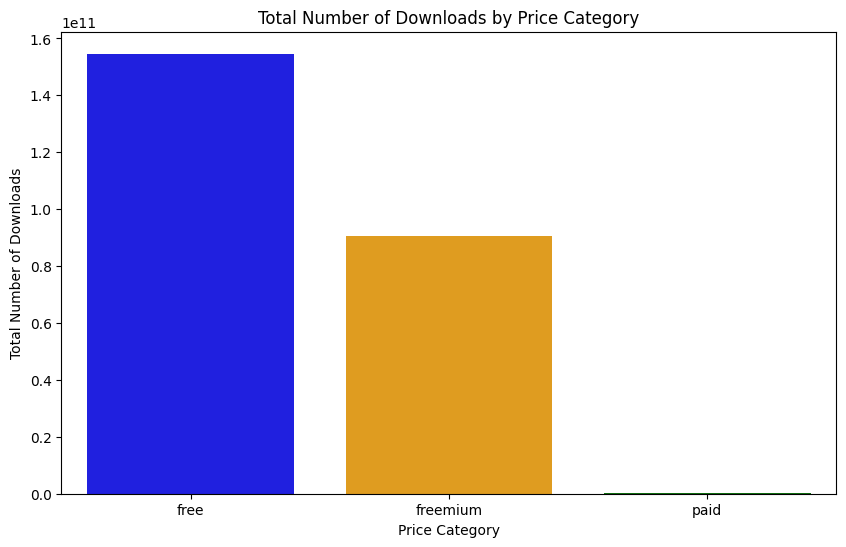

In [26]:
# Calculate the total number of downloads for each price category
total_downloads = df_filtered.groupby('price_category')['num_downloads'].sum().reset_index()

# Set up a color palette for price categories
palette = {"free": "blue", "paid": "green", "freemium": "orange"}

# Plot the total number of downloads by price category with the updated parameters
plt.figure(figsize=(10, 6))
sns.barplot(data=total_downloads, x='price_category', y='num_downloads', hue='price_category', palette=palette, dodge=False)
plt.legend([], [], frameon=False)  # Remove the legend

# Add labels and a title
plt.title("Total Number of Downloads by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Total Number of Downloads")
plt.show()


#### 3.2.2.1 Average downloads

In [27]:
# Calculate the mean number of downloads for each price category
mean_freemium = df_filtered[df_filtered['price_category'] == 'freemium']['num_downloads'].mean()
mean_free = df_filtered[df_filtered['price_category'] == 'free']['num_downloads'].mean()
mean_paid = df_filtered[df_filtered['price_category'] == 'paid']['num_downloads'].mean()


In [28]:
# Create a dictionary for the means
means = {
    'Free': mean_free,
    'Freemium': mean_freemium,
    'Paid': mean_paid,
}

# Convert to a pandas DataFrame for easier plotting
mean_df = pd.DataFrame(list(means.items()), columns=['Price Category', 'Average Downloads'])


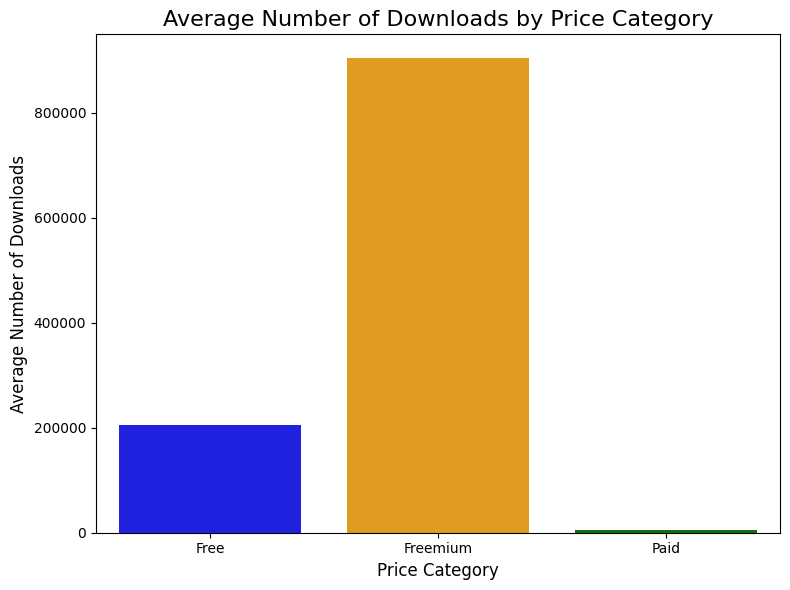

In [29]:
# Set up a color palette for price categories
palette = {"Free": "blue", "Paid": "green", "Freemium": "orange"}

# Set up the plot
plt.figure(figsize=(8, 6))

# Create the bar plot with the updated parameters
sns.barplot(x='Price Category', y='Average Downloads', data=mean_df, hue='Price Category', palette=palette, dodge=False)
plt.legend([], [], frameon=False)  # Removes the legend

# Add labels and a title
plt.title('Average Number of Downloads by Price Category', fontsize=16)
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Average Number of Downloads', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### 3.2.3 Rating by Price Category

In [30]:
# Set up a color palette for price categories
palette = {"free": "blue", "paid": "green", "freemium": "orange"}

#### 3.2.3.1 Average Rating

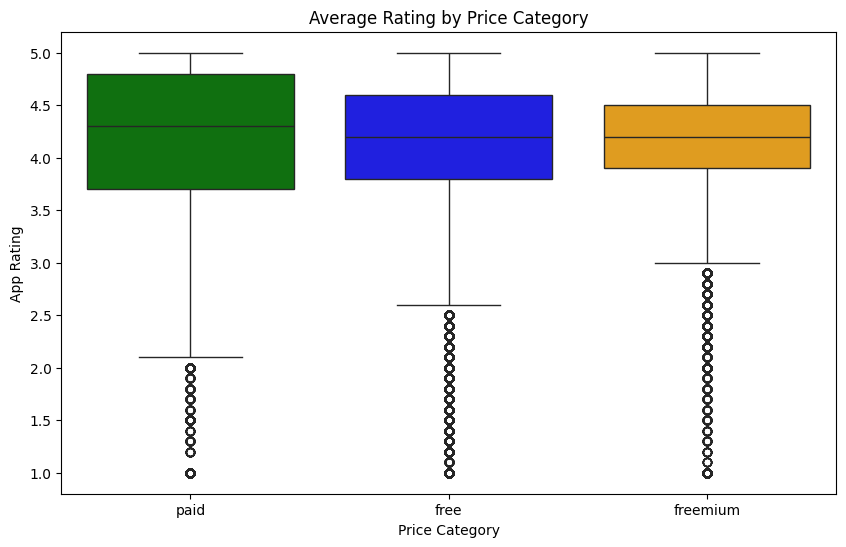

In [31]:
# Average Rating by Price Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='price_category', y='rating_app', hue='price_category', palette=palette, legend=False)
plt.title("Average Rating by Price Category")
plt.xlabel("Price Category")
plt.ylabel("App Rating")
plt.show()


#### 3.2.3.2 Average Bayesian Rating

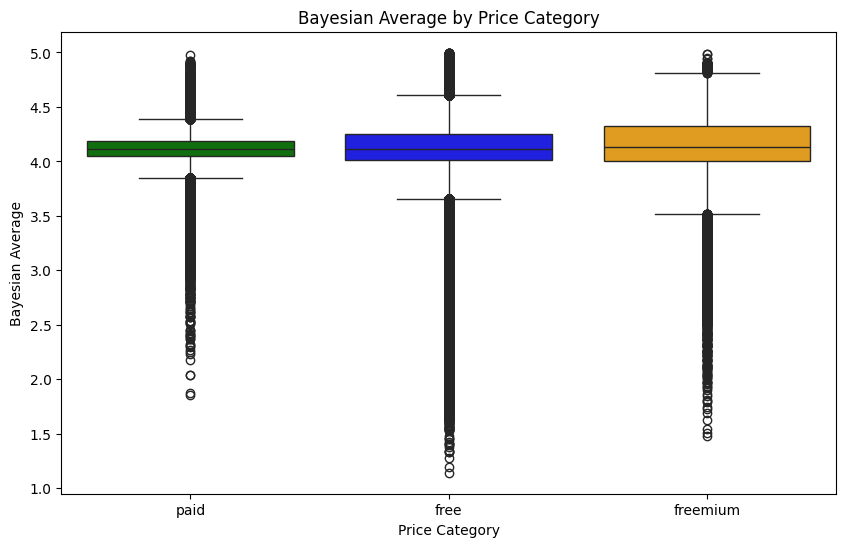

In [32]:
# Bayesian Average by Price Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='price_category', y='bayesian_average', hue='price_category', palette=palette, legend=False)
plt.title("Bayesian Average by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Bayesian Average")
plt.show()


#### 3.2.3.3 Average Number of Ratings

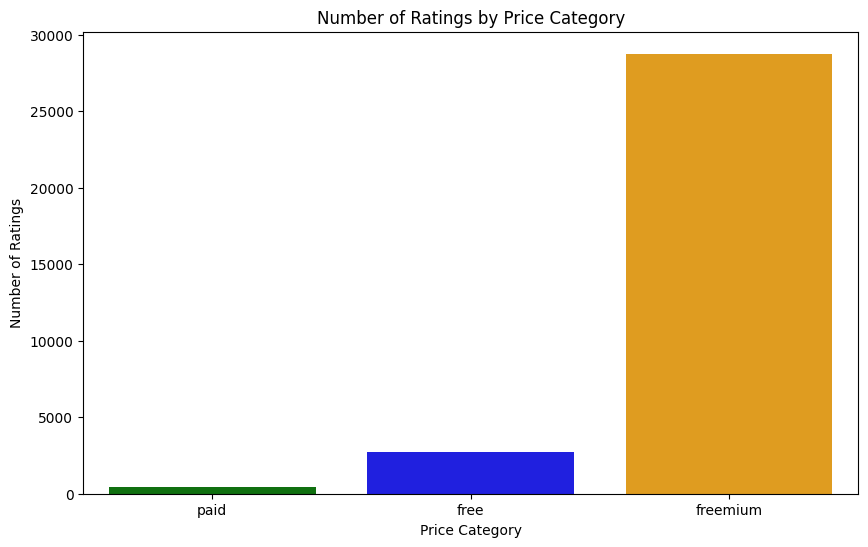

In [33]:
# Number of Ratings by Price Category
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='price_category', y='nb_rating', hue='price_category', palette=palette, errorbar=None, legend=False)
plt.title("Number of Ratings by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Number of Ratings")
plt.show()

#### 3.2.3.4 Total Number of Ratings

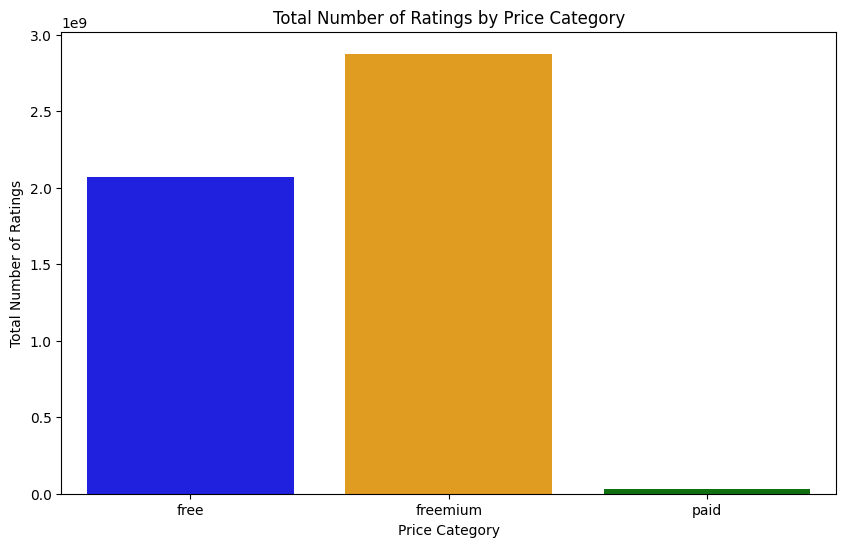

In [34]:
# Calculate the total number of ratings for each price category
total_ratings = df_filtered.groupby('price_category')['nb_rating'].sum().reset_index()

# Plot the total number of ratings by price category
plt.figure(figsize=(10, 6))
sns.barplot(data=total_ratings, x='price_category', y='nb_rating', hue='price_category', palette=palette, dodge=False)
plt.legend([], [], frameon=False)  # Remove the legend if not needed

# Add labels and a title
plt.title("Total Number of Ratings by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Total Number of Ratings")
plt.show()

### 3.2.4 TODO: Outliers

### 3.2.5 TODO: Distribution of free, freemium, paid. Average downloads per category



# 4. Merge SDK dataset

In [35]:
# read app_sdk/app_sdk.csv
app_sdk = pd.read_csv('app_sdk/app_sdk.csv')
app_sdk = app_sdk.loc[:, ~app_sdk.columns.str.contains('^Unnamed')]

C:\Users\Kevin\AppData\Local\Temp\ipykernel_33588\1449197697.py:2: DtypeWarning: Columns (2,3,5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  app_sdk = pd.read_csv('app_sdk/app_sdk.csv')


In [36]:
# join df and app_sdk on inner join with my_app_id and id
df_app_and_sdk = pd.merge(df_filtered, app_sdk, left_on='my_app_id', right_on='id', how='inner')

# 5. Graphs SDK

## 5.1 SDK_name counts

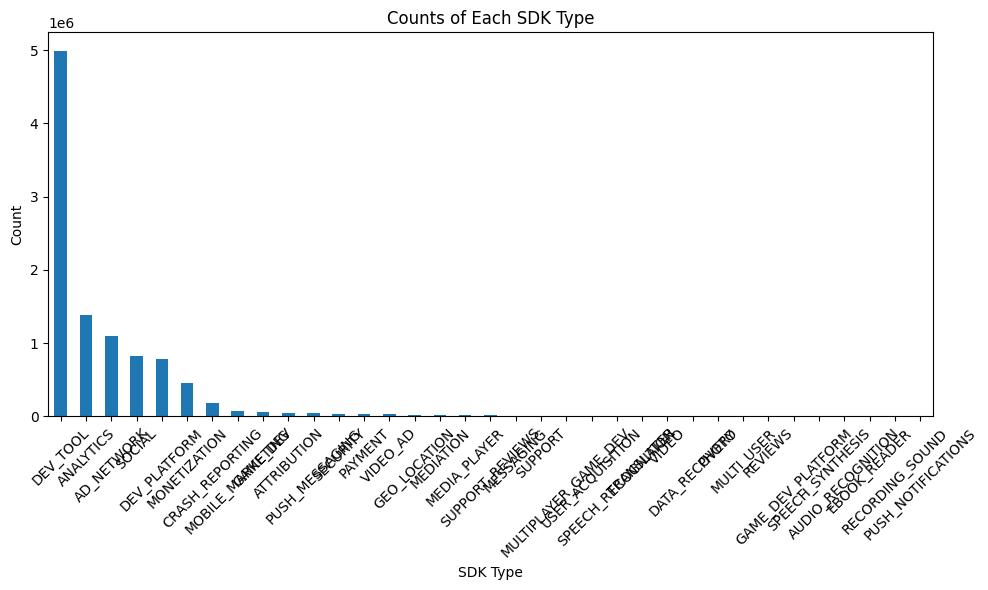

In [37]:
# Plotting the counts of each SDK name
plt.figure(figsize=(10, 6))
df_app_and_sdk['sdk_type'].value_counts().plot(kind='bar')
plt.title("Counts of Each SDK Type")
plt.xlabel("SDK Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.2 Top 10 used SDKs

In [38]:
# top 10 most used SDKs by free apps
df_free = df_app_and_sdk[df_app_and_sdk['price_category'] == 'free']
df_free = df_free.dropna(subset=['sdk_name'])
df_free = df_free['sdk_name'].value_counts().head(10)
df_free

sdk_name
Google Analytics              503771
Google                        459870
Google Mobile Ads             407904
Google Sign-In                383687
Google Maps                   361770
Google Search Actions         312081
DoubleClick for Publishers    309229
Firebase                      259069
Tag Manager                   193399
Google Cloud Messaging        184816
Name: count, dtype: int64

In [39]:
# top 10 most used SDKs by freemium apps
df_freemium = df_app_and_sdk[df_app_and_sdk['price_category'] == 'freemium']
df_freemium = df_freemium.dropna(subset=['sdk_name'])
df_freemium = df_freemium['sdk_name'].value_counts().head(10)
df_freemium

sdk_name
Google Analytics              113175
Google                         87702
Android                        83617
Google Mobile Ads              80233
Google Sign-In                 78325
Google Maps                    72929
DoubleClick for Publishers     67906
Google Search Actions          67902
Firebase                       58118
Tag Manager                    43274
Name: count, dtype: int64

In [40]:
# top 10 most used SDKs by paid apps
df_paid = df_app_and_sdk[df_app_and_sdk['price_category'] == 'paid']
df_paid = df_paid.dropna(subset=['sdk_name'])
df_paid = df_paid['sdk_name'].value_counts().head(10)
df_paid

sdk_name
Google                   221
Google Analytics         143
Android                  121
Google Mobile Ads        117
Google Sign-In           114
Google Maps              102
Google Search Actions     98
Firebase                  78
Unity                     66
FMOD Studio               65
Name: count, dtype: int64

## 5.3 Top 10 used SDKs dropping duplicates

In [41]:
df_new = df_app_and_sdk.drop_duplicates(subset=['my_app_id', 'sdk_name'])

In [42]:
df_free = df_new[df_new['price_category'] == 'free']
df_freemium = df_new[df_new['price_category'] == 'freemium']
df_paid = df_new[df_new['price_category'] == 'paid']

In [45]:
df_free['sdk_name'].value_counts().head(10)

sdk_name
Google                        458645
Google Mobile Ads             406823
Google Sign-In                382621
Google Maps                   360744
Google Search Actions         311214
DoubleClick for Publishers    308249
Google Analytics              253231
Firebase                      250092
Tag Manager                   192737
Google Cloud Messaging        184227
Name: count, dtype: int64

In [46]:
df_freemium['sdk_name'].value_counts().head(10)

sdk_name
Google                        86112
Android                       82046
Google Mobile Ads             78773
Google Sign-In                76870
Google Maps                   71520
Google Search Actions         66652
DoubleClick for Publishers    66519
Google Analytics              57271
Firebase                      55155
Tag Manager                   42308
Name: count, dtype: int64

In [47]:
df_paid['sdk_name'].value_counts().head(10)

sdk_name
Google                   198
Android                  107
Google Mobile Ads        104
Google Sign-In           102
Google Maps               91
Google Search Actions     86
Firebase                  68
Google Analytics          67
Unity                     59
FMOD Studio               58
Name: count, dtype: int64